In [297]:
import os
import glob
import math
import pickle
import random
import datetime
from collections import defaultdict
import copy
from enum import Enum
import numpy as np 
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Module
import tqdm
import gym
from gym import Env
from gym.spaces import Box, Discrete
from gym.utils.env_checker import check_env
from typing import (
    Type,
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [298]:
print(stable_baselines3.__version__)
print(gym.__version__) # should be 0.21.0 to be compatible with stable_baselines3 1.8

1.8.0
0.21.0



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

In [299]:
import math
N = 100
lower_bound = -5
upper_bound = 5

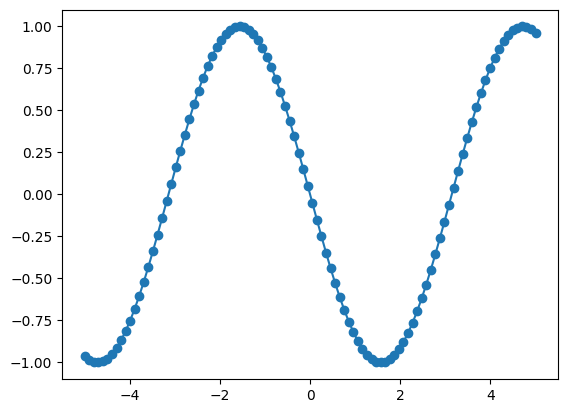

In [300]:
plt.plot(np.linspace(upper_bound, lower_bound, N), np.sin(np.linspace(lower_bound, upper_bound, N)), marker='o')

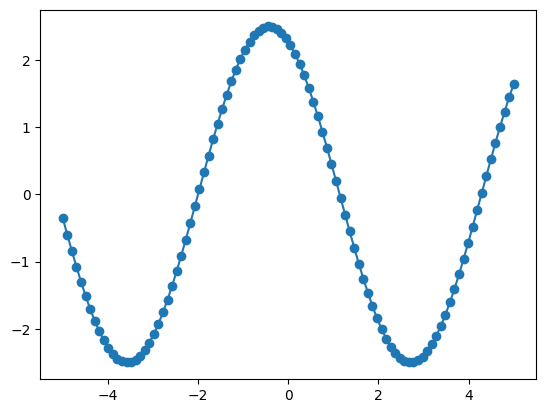

In [301]:
amp = 2.5
phase_shift = 2
plt.plot(np.linspace(lower_bound, upper_bound, N), amp*np.sin([x + phase_shift for x in np.linspace(lower_bound, upper_bound, N)]), marker='o')
# increasing amplitude to 2.5 with phase shift 2

In [302]:
x_np = np.linspace(lower_bound, upper_bound, N) 
x = torch.from_numpy(x_np)
print(x.dtype)

torch.float64


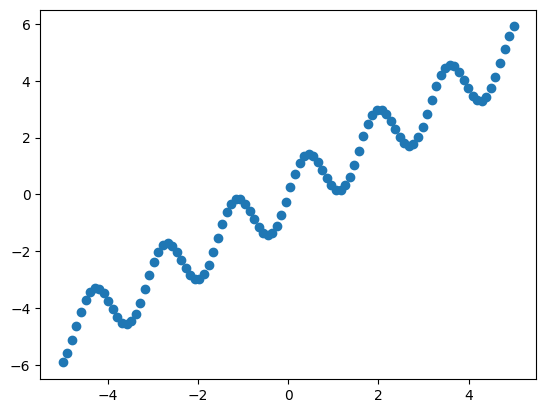

In [124]:
sine_wave = x + np.sin(4*x)
plt.plot(x, sine_wave, 'o');

In [178]:
def save_model(model: torch.nn.Module,path: str) -> None:
    torch.save(model.state_dict(), path)

def load_model(model: torch.nn.Module, path: str) -> torch.nn.Module:
    model.load_state_dict(torch.load(path))    
    
def split_data(X: np.ndarray, y: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # wraps sklearn's train_test_split
    # added functionality is converting to torch tensor type and reshaping
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

# meta learner's predict() for task data 
def predict_task_yhats_with_target_network(layers, X):
    print('[INFO] X has shape {0}'.format(X.shape))
    y_hats = []
    for x in X:
        print('[INFO] x in X has shape {0}'.format(x.shape))
        x = torch.tensor(x)
        for i in range(len(layers)-1):
            x = torch.nn.functional.relu(layers[i](x))
        x = layers[-1](x) # do not relu the very last calculation
        y_hats.append(x)

    return y_hats # where each y_hat for each x in X is the latent space calculation

def predict(model: torch.nn.Module, X: torch.Tensor) -> List[torch.Tensor]:
    # function to get yhat from target network
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, y: torch.Tensor, y_hat: torch.Tensor, plot_title: str="line fit") -> None:
    # function to plot predicted curve versus actual curve
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions()
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)

def calculate_pool_size(num_tasks, num_layers_per_network):
    k = 1
    return num_tasks * num_layers_per_network * k


## sinusoidal datasets as defined in MAML paper

In [179]:
N_X = 100
N_TASKS = 20
x_values = np.linspace(lower_bound, upper_bound, N_X) 
amplitude_range = [0.1, 5.0]
phase_range = [0, math.pi]
amps = np.linspace(amplitude_range[0], amplitude_range[1], N_TASKS)
phases = np.linspace(phase_range[0], phase_range[1], N_TASKS)
x = np.linspace(lower_bound, upper_bound, N_X) 
sin_sets = [
    (x, (a * np.sin(x)) + p) 
    for (a, p) in zip(amps, phases)]

## config

In [203]:
config = {
    'SEED' :123,
    'DEVICE' : 'cpu',
    'EPOCHS' : 2,
    'TIMESTEPS' : 1000,
    'N_X' : 200,
    'N_TASKS' : 10,
    'N_LAYERS_PER_NETWORK' : 10,
    'N_NODES_PER_LAYER' : 32,
    'POOL_LAYER_TYPE' : torch.nn.Linear,
    'ACTION_SPACE_SHAPE' : (3,),
    'EPSILON' : 0.1,
    'BATCH_SIZE' : 1,
    'LEARNING_RATE' : 0.05,
    'ACTION_CACHE_SIZE' : 5,
    'NUM_WORKERS' : 0,
    'LOSS_FN' : torch.nn.MSELoss(),
    'SB3_MODEL' : PPO,
    'SB3_POLICY' : 'MlpPolicy',
    }
config['POOL_N_LAYERS'] = calculate_pool_size(config['N_TASKS'], config['N_LAYERS_PER_NETWORK'])
print(config)

{'SEED': 123, 'DEVICE': 'cpu', 'EPOCHS': 2, 'TIMESTEPS': 1000, 'N_X': 200, 'N_TASKS': 10, 'N_LAYERS_PER_NETWORK': 10, 'N_NODES_PER_LAYER': 32, 'POOL_LAYER_TYPE': <class 'torch.nn.modules.linear.Linear'>, 'ACTION_SPACE_SHAPE': (3,), 'EPSILON': 0.1, 'BATCH_SIZE': 1, 'LEARNING_RATE': 0.05, 'ACTION_CACHE_SIZE': 5, 'NUM_WORKERS': 0, 'LOSS_FN': MSELoss(), 'SB3_MODEL': <class 'stable_baselines3.ppo.ppo.PPO'>, 'SB3_POLICY': 'MlpPolicy', 'POOL_N_LAYERS': 100}


## Reinforcement Meta-Learning (REML) / "Learning to Learn by Gradient Descent as a Markov Deicision Process"

- layer pool
- inner network -- composed of layers from layer pool
- outer network (meta learner) -- responsible for parameters and hyperparameters of inner network

In [204]:
class Layer:
    def __init__(self, 
                type: Type[torch.nn.Module]=config['POOL_LAYER_TYPE'],
                params: Type[torch.nn.Module]=config['POOL_LAYER_TYPE']):
        self.type = type
        self.params = params
        self.used = False
        self.times_used = 0

class LayerPool:
    # pool of uniform Layer objects each with the same type and shape
    def __init__(self, 
                size: int=config['POOL_N_LAYERS'], 
                layer_type: Type[torch.nn.Module]=config['POOL_LAYER_TYPE'],
                num_nodes_per_layer: int=config['N_NODES_PER_LAYER']):
        self.size = size
        self.layer_type = layer_type
        self.num_nodes_per_layer = num_nodes_per_layer

        # each layer that is used gets updated (i.e., their parameters change and the copy in 
        # this layer pool is updated), except for the first and last layers which are unique
        # for each task
        self.layers = {
            i : Layer(
                type=self.layer_type, 
                params=self.layer_type(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer)
                )
            for i in range(size)}

        [torch.nn.init.xavier_uniform_(layer.params.weight) for layer in self.layers.values()]
        
    def __str__(self):
        return f"LayerPool(size={self.size}, layer_type={config['POOL_LAYER_TYPE']}, num_nodes_per_layer={config['N_NODES_PER_LAYER']}"



In [205]:
class InnerNetworkAction(Enum):
    TRAIN = 0
    ADD = 1
    DELETE = 2

In [222]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == N_X, '[ERROR] Length should be the same as N_X.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info[index]
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data, self.targets}, info={self.info})'

In [379]:
class InnerNetwork(gym.Env, Module):
    def __init__(self, 
                task: InnerNetworkTask,
                layer_pool: LayerPool,
                num_layers_per_network: int=config['N_LAYERS_PER_NETWORK'],
                learning_rate: float=config['LEARNING_RATE'],
                batch_size: int=config['BATCH_SIZE'],
                epsilon: float=config['EPSILON'],
                action_cache_size: float=config['ACTION_CACHE_SIZE'],
                num_workers: int=config['NUM_WORKERS'],
                shuffle: bool=True,
                ):
        super(InnerNetwork, self).__init__()
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.layer_pool = layer_pool
        self.num_layers_per_network = num_layers_per_network
        self.task = task
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.data_iter = iter(self.data_loader)
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.initial_layer = torch.nn.Linear(1, self.layer_pool.num_nodes_per_layer) # TODO is to have param with input_shape
        self.final_layer = torch.nn.Linear(self.layer_pool.num_nodes_per_layer, 1) # TODO is to have param with output_shape
        torch.nn.init.xavier_uniform_(self.final_layer.weight)
        torch.nn.init.xavier_uniform_(self.initial_layer.weight)
        self.layers = torch.nn.ModuleList([self.initial_layer, self.final_layer])
        self.pool_indices = [] 
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=learning_rate)
        self.action_cache_size = action_cache_size
        self.actions_taken = []
        # TODO is to consider normalizing the state output from build_state
        self.state = self.reset()
        self.observation_space = Box(low=float('-inf'), high=float('inf'), shape=self.build_state().shape)
        self.action_space = Discrete(self.layer_pool.size * 2 + 1)

    def step(self, action: np.ndarray) -> Tuple[torch.Tensor, float, bool, dict]: 
        assert action.shape == (self.action_space.n,)
        assert action.dtype == np.float32, '[ERROR] Expected np.float32 dtype, got: {0}'.format(action.dtype)
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)
        action_index = self.epsilon_greedy(action)
        self.update_inner_network(action_index)
        self.forward_inner_network()
        s_prime = self.build_state()
        reward = self.reward(s_prime)
        return (
            s_prime,
            reward, 
            False, 
            {}
        )
    
    def epsilon_greedy(self, action: np.ndarray):
        if random.random() <= self.epsilon: action_index = random.randint(0, len(action)-1)
        else: action_index = np.argmax(action)
        return action_index
    
    def update_inner_network(self, action_index: int):
        if (action_index == len(self.action_space.n)-1): action_type = InnerNetworkAction.TRAIN
        if (action_index <= self.layer_pool.size): action_type = InnerNetworkAction.ADD
        if (action_index > self.layer_pool.size): action_type = InnerNetworkAction.DELETE

        if (action_type == InnerNetworkAction.TRAIN):
            print('[INFO] "Train" action taken by inner network.')
            self.actions_taken.append(InnerNetworkAction.TRAIN)
            self.curr['action_type'] = InnerNetworkAction.TRAIN

        if (action_type == InnerNetworkAction.ADD):
            print('[INFO] "Add" action taken by inner network.')
            self.pool_indices.append(i)
            next_layer = self.layer_pool.layers[i].layer
            final_layer = self.layers.pop(-1)
            self.layers.append(next_layer)  
            self.layers.append(final_layer) 
            self.actions_taken.append(InnerNetworkAction.ADD)
            self.curr['action_type'] = InnerNetworkAction.ADD

        if (action_type == InnerNetworkAction.DELETE):
            print('[INFO] "Delete" action taken by inner network.')
            self.pool_indices.remove(i)
            layer_to_delete = self.layer_pool.layers[i].layer
            index = self.layers.index(layer_to_delete)
            assert layer_to_delete == self.layers[index], '[ERROR] Wrong layer would be deleted from inner network params.'
            self.layers.pop(index)
            self.actions_taken.append(InnerNetworkAction.DELETE)
            self.curr['action_type'] = InnerNetworkAction.DELETE

    def next_batch(self) -> dict:
        try:
            batch = next(self.data_iter)
            return batch
        except StopIteration:
            self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)
            self.data_iter = iter(self.data_loader)
            batch = next(self.data_iter)
            return batch

    def forward_inner_network(self) -> None: 
        batch = self.next_batch()
        self.curr['x'] = batch['x']
        self.curr['y'] = batch['y'] 
        self.curr['info'] = batch['info']
        if self.curr['action_type'] == InnerNetworkAction.TRAIN:
            self.train() # needs to be called before forward pass for gradient information to be saved
            self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
            self.opt.zero_grad()
        else:
            self.eval()
        # forward pass
        x = self.curr['x']
        for i in range(len(self.layers) - 1):
            x = torch.nn.functional.relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        self.curr['loss'] = torch.nn.MSELoss(self.curr['y'], self.curr['y_hat'])
        assert self.curr['latent_space'].dtype == torch.float32
        assert self.curr['y_hat'].dtype == torch.float32
        # update params if 'train'
        if (self.curr['action_type'] == InnerNetworkAction.TRAIN):
            loss = self.curr['loss']
            loss.backward()
            self.opt.step()

    def build_state(self) -> torch.Tensor
        num_add_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.ADD, self.actions_taken)))).unsqueeze(0)
        num_delete_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.DELETE, self.actions_taken)))).unsqueeze(0)
        num_train_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.TRAIN, self.actions_taken)))).unsqueeze(0)
        num_layers = torch.tensor(len(self.layers))
        h = torch.tensor(self.actions_taken[-self.action_cache_size:])
        task_info = torch.tensor([float(value) for value in self.curr['info'].values()]).float()
        return torch.concat((
            task_info,
            self.curr['x'],
            self.curr['latent_space'],
            self.curr['y'],
            self.curr['y_hat'],
            num_add_actions,
            num_delete_actions,
            num_train_actions,
            num_layers,
            h
        ), dim=0)
    
    def reward(self) -> torch.Tensor:
        prev_loss = self.prev['loss']
        curr_loss = self.curr['loss']
        assert prev_loss != curr_loss, '[ERROR] Loss values from previous and current run are equal.'
        delta_loss = prev_loss - curr_loss
        curr_action = self.curr['action_type']
        if (curr_action == InnerNetworkAction.ADD):
            reward = torch.tensor(delta_loss / math.sqrt(len(self.layers)))
        else:
            reward = torch.tensor(delta_loss)
        return reward

    def reset(self) -> np.ndarray:
        # TODO is to better understand when reset is called and what we should (e.g., do we reset the module list?)
        # self.layers = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer])
        self.forward_inner_network()
        return self.build_state()
    
    # def render(self, mode='human', close=False):
    #     pass

    def close(self):
        pass

    def evaluate(self):
        self.eval()
        y_hats = []
        for x in self.task['data']:
            x = torch.tensor([x])
            for i in range(len(self.layers)-1):
                x = torch.nn.functional.relu(self.layers[i](x))
            x = self.layers[-1](x) # do not relu the very last calculation
            y_hats.append(x)
        return y_hats

In [380]:
class REML:
    def __init__(
        self,
        layer_pool: LayerPool,
        tasks: List[InnerNetworkTask],
        model=config['SB3_MODEL'],
        policy=config['SB3_POLICY'],
        epochs: int=config['EPOCHS'],
        timesteps: int=config['TIMESTEPS'],
        device: str=config['DEVICE'],
        overwrite: bool=True,  # TODO is to revisit this param
        intra_update: bool=True, # TODO is to revisit this param
        ):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.model = model
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.device = device
        self.overwrite = overwrite 
        self.intra_update = intra_update
        # TODO is to revisit how we save and how we view (to tensorboard? weightsandbiases?)
        self.runs_path = os.path.join(os.getcwd(), 'runs')
        self.yhats_by_epoch_by_task = {}
        self.layerindices_by_epoch_by_task = {}

    def train(self):
        # wraps stablebaselines learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 
        # therefore the number of steps is (timesteps)*(n)*(m)
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch {epoch + 1}/{self.epochs}')

            task_to_yhats = {}
            task_to_layerindices = {}
            for i, task in enumerate(self.tasks): 
                print(f'[INFO] Task num={i+1}/{len(self.tasks)}')

                # each task gets its own network
                env = InnerNetwork(task, self.layer_pool)
                
                # update env to be the new task
                if epoch==0: model = self.model(self.policy, env) 
                else: model.set_env(env)

                # train reml for 20000 timesteps, which means output 20000
                # actions to the inner network. Each timestep is an action given to
                # inner network. This in turn is a step in the environment. Therefore
                # we update the parameters of inner loop and outerloop each 20000
                # times. Timestep in outer is env step in inner. The loss of the inner 
                # network is part of the reward signal to outer network.
                #
                # NOTE: this will be changed to discrete-continuous hybrid action space
                # used a P-DQN that leverages both DDPG and DQN networks. This learn
                # method will no longer exists from the stable baselines 3 api and 
                # will require me to write a method similar to this that calls an
                # act() method n timesteps times, gets the discrete action with its
                # action parameters, then evalutes the inner network performance, then
                # calculate reward function and makes gradient steps for both of the
                # inner DDPG and DQN networks
                model.learn(total_timesteps=self.timesteps) # steps within gym env

                # get loss for all of the task's X values
                # NOTE: why for all X values? we have the network already built by 
                # the agent. during the timesteps, we stepped through the env with 
                # each x in X. now we just want to predict to see how that tuned
                # inner network performs.
                y_hats = env.evaluate()

                # save task data to plot how well the target network
                # does for this task for this epoch
                task_to_yhats[task.info] = y_hats
                task_to_layerindices[task.info] = env.pool_indices

                # update pool
                for i in range(len(env.pool_indices)):
                    pool_index = env.pool_indices[i]
                    updated_layer_copy = env.layers[i+1]
                    self.layer_pool.layers[pool_index].layer = updated_layer_copy
                    self.layer_pool.layers[pool_index].used = True
                    self.layer_pool.layers[pool_index].times_used += 1
            
            # save indiviudal epoch data
            self.yhats_by_epoch_by_task[epoch] = task_to_yhats
            self.layerindices_by_epoch_by_task[epoch] = task_to_layerindices

    def save(self):
        today = datetime.date.today().strftime('%Y-%m-%d')
        today_runs = [path for path in glob.glob(os.path.join(self.runs_path, '*.pkl')) if today in path] 
        num = int(len(today_runs) / 3 if today_runs else 0)

        yhats_pkl_name = os.path.join(self.runs_path, "{0}_{1}_yhats.pkl".format(today, num))
        indices_pkl_name = os.path.join(self.runs_path, "{0}_{1}_indices.pkl".format(today, num))
        pool_pkl_name = os.path.join(self.runs_path,"{0}_{1}_pool.pkl".format(today, num))

        with open(yhats_pkl_name, 'wb') as yhats_pkl:
            pickle.dump(self.yhats_by_epoch_by_task, yhats_pkl)

        with open(indices_pkl_name, 'wb') as indices_pkl:
            pickle.dump(self.layerindices_by_epoch_by_task, indices_pkl)

        with open(pool_pkl_name, 'wb') as pool_pkl:
            pickle.dump(self.layer_pool, pool_pkl)
    
    def load(self):
        yhats_loaded, indices_loaded, pool_loaded = {}, {}, {}
        paths = os.listdir(self.runs_path)
        yhats_pkl_name = [path for path in paths if 'yhats' in path][0]
        indices_pkl_name = [path for path in paths if 'indices' in path][0]
        pool_pkl_name = [path for path in paths if 'pool' in path][0]
        
        print(paths)

        with open(os.path.join(self.runs_path, yhats_pkl_name), 'rb') as yhats_pkl:
            yhats_loaded = pickle.load(yhats_pkl)

        with open(os.path.join(self.runs_path, indices_pkl_name), 'rb') as indices_pkl:
            indices_loaded = pickle.load(indices_pkl)

        with open(os.path.join(self.runs_path, pool_pkl_name), 'rb') as pool_pkl:
            pool_loaded = pickle.load(pool_pkl)
        
        return yhats_loaded, indices_loaded, pool_loaded

### baby example with just 2 epochs
However, 2 epoch is still going through all 20 tasks, generating 20 different networks, using the same 1 meta policy. Also, on each task we loop through the data 1000 times (timesteps / len(X) == 10000 / 100).
<br>
The benefit of more epochs is we get the meta policy to gnerate 20 different networks again for the 20 tasks, having hopefully learned something from the first run.

In [381]:
# create tasks
X = np.linspace(lower_bound, upper_bound, N_X)
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], N_TASKS)).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], N_TASKS)).float()

# (20, 100)
tasks_data = torch.tensor([ 
        X
        for _ in range(N_TASKS)
        ]).float()
tasks_targets = torch.tensor([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ]).float()
tasks_info = [
        [{'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
         for _ in X]
        for i, (a, p) in enumerate(zip(amps, phases))
]

In [382]:
print(tasks_data.shape)
print(tasks_data.dtype)
print(tasks_targets.shape)
print(tasks_targets.dtype)
print(len(tasks_info))
print(len(tasks_info[0]))

torch.Size([20, 100])
torch.float32
torch.Size([20, 100])
torch.float32
20
100


In [383]:
# create tasks
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(N_TASKS)]
# create pool
pool = LayerPool()
# create REML
model = REML(layer_pool=pool, tasks=tasks)

In [384]:
# train
model.train()

[INFO] Epoch 1/2
[INFO] Task num=1/20


C:\Users\stach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
# save 
model.save()

In [ ]:
# load
yhats_by_epoch_by_task, indices_by_epoch_by_task, pool = model.load()

['2023-09-13_0_indices.pkl', '2023-09-13_0_pool.pkl', '2023-09-13_0_yhats.pkl', '2023-09-13_1_indices.pkl', '2023-09-13_1_pool.pkl', '2023-09-13_1_yhats.pkl']


In [ ]:
for (task_id, data) in tasks.items():
    print(task_id)
    print()
    print(data[1])
    print()
    print(yhats_by_epoch_by_task[0][task_id])

task_n=0_amp=0.1_phase=0.0

[ 0.09589243  0.09826405  0.09963393  0.09998811  0.09932298  0.0976453
  0.0949722   0.09133091  0.08675857  0.08130177  0.07501615  0.0679658
  0.06022257  0.05186541  0.04297952  0.03365548  0.02398834  0.01407665
  0.00402147 -0.00607471 -0.01610897 -0.025979   -0.0355842  -0.04482664
 -0.05361209 -0.06185101 -0.06945939 -0.07635968 -0.08248153 -0.08776254
 -0.09214885 -0.09559578 -0.09806816 -0.0995408  -0.09999868 -0.09943714
 -0.0978619  -0.09528902 -0.09174473 -0.08726516 -0.08189598 -0.07569192
 -0.06871622 -0.06104001 -0.05274154 -0.0439054  -0.03462167 -0.02498499
 -0.01509361 -0.00504836  0.00504836  0.01509361  0.02498499  0.03462167
  0.0439054   0.05274154  0.06104001  0.06871622  0.07569192  0.08189598
  0.08726516  0.09174473  0.09528902  0.0978619   0.09943714  0.09999868
  0.0995408   0.09806816  0.09559578  0.09214885  0.08776254  0.08248153
  0.07635968  0.06945939  0.06185101  0.05361209  0.04482664  0.0355842
  0.025979    0.01610897  

In [541]:
# ask by epoch ("0") then by task id ("task_n=0_amp=0.1_phase=0.0")
yhats_by_epoch_by_task[0]['task_n=0_amp=0.1_phase=0.0']

[tensor([-0.0148, -0.0514, -0.0476, -0.0067,  0.0180, -0.0365, -0.0004,  0.0083,
         -0.0035, -0.0081, -0.0313,  0.0070, -0.0415,  0.0268, -0.0119, -0.0315,
         -0.0052, -0.0336, -0.0327, -0.0082, -0.0355, -0.0266, -0.0330, -0.0146,
         -0.0198, -0.0060, -0.0076, -0.0250, -0.0173,  0.0050, -0.0524, -0.0417,
          0.0230, -0.0016, -0.0285, -0.0092,  0.0065, -0.0380, -0.0166, -0.0277,
          0.0005,  0.0019, -0.0245, -0.0329,  0.0104, -0.0129,  0.0201, -0.0439,
         -0.0121,  0.0147,  0.0227, -0.0316, -0.0210, -0.0507, -0.0504,  0.0078,
         -0.0250, -0.0271, -0.0335, -0.0380, -0.0115, -0.0113, -0.0327, -0.0396,
         -0.0216, -0.0352, -0.0287, -0.0546, -0.0403, -0.0002,  0.0221, -0.0135,
          0.0075, -0.0564, -0.0447, -0.0175, -0.0492, -0.0495,  0.0211, -0.0395,
         -0.0481, -0.0344, -0.0224, -0.0240, -0.0243, -0.0278, -0.0198, -0.0378,
         -0.0440, -0.0166,  0.0038, -0.0166, -0.0289, -0.0157, -0.0242, -0.0172,
         -0.0223, -0.0174, -

[array(0.01271912), array(0.25434825), array(0.76286647), array(1.6038723), array(2.75709625), array(7.46422505), array(8.7766633), array(10.17492831), array(20.68788337), array(21.02281967)]


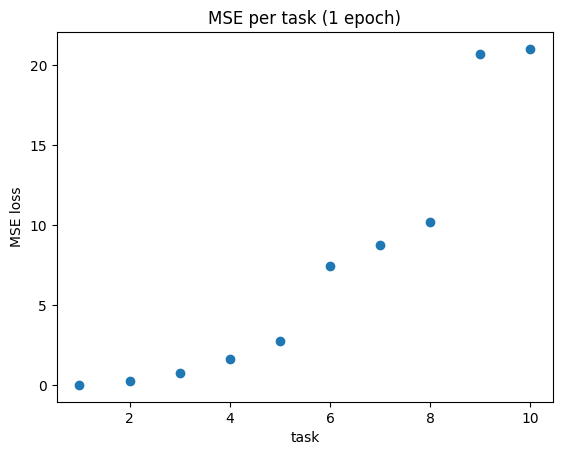

In [567]:
# plot performance
plt.xlabel('task')
plt.ylabel('MSE loss')
plt.title('MSE per task (1 epoch)')

# calculate loss values as average for the task for the epoch
loss_by_task = []
for (task_id, data) in tasks.items(): # 5 tasks
    for y_hats in yhats_by_epoch_by_task[0][task_id]: # 1 epoch
        losses = []
        for y, y_hat in zip(data[1], y_hats): # 100 values
            y_hat = y_hat.unsqueeze(0)
            y = torch.tensor(y).unsqueeze(0) # can't iterate over 0d tensors
            loss = F.mse_loss(y, y_hat)
            losses.append(loss)
    loss_by_task.append( (sum(losses)/len(losses)).detach().numpy() ) # can't plot tensor values
print(loss_by_task)

plt.scatter(
    range(1, N_TASKS + 1), 
    loss_by_task
    );

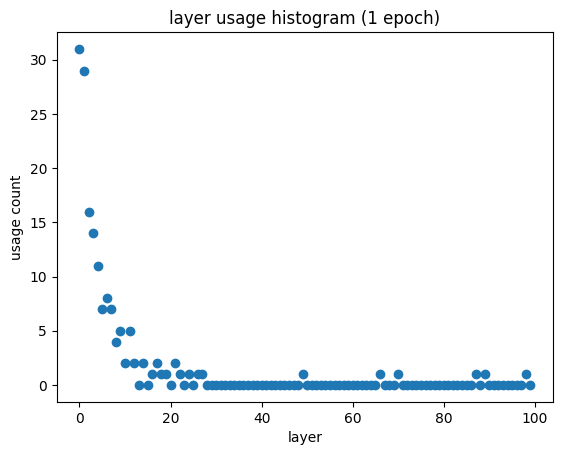

In [568]:
# plot layer use for all tasks
plt.xlabel('layer')
plt.ylabel('usage count')
plt.title('layer usage histogram (1 epoch)')
plt.scatter(
    range(N_X), 
    [layer.times_used for layer in pool.layers.values()]
    );

### Loss w/ transfer vs. w/o transfer

In [ ]:
# y - loss
# x - timesteps

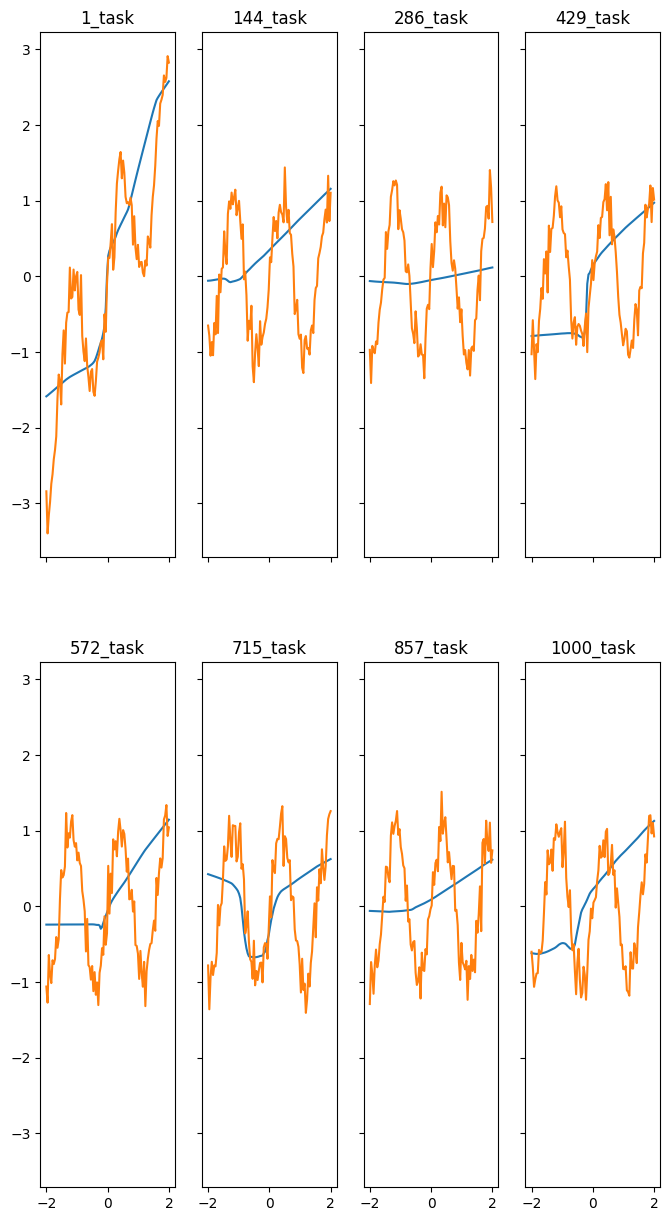

In [74]:
# PRINT PLOTS
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8,15))
k = 0
for i in range(rows):
    for j in range(cols):
        task = list(task_to_yhats.keys())[k]
        y_hats = task_to_yhats[task]
        axs[i, j].plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
        axs[i, j].plot(X, list(tasks.items())[k][1])
        axs[i,j].set_title(task)
        k+=1